<a href="https://colab.research.google.com/github/arshpreetsingh134/Image_to_speech/blob/main/image_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!pip freeze | grep "pycocotools"

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-qz8x0ynk
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-qz8x0ynk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266605 sha256=f2370a50a253979fbc0e636fc7c4411a49631569661851ff9c21f10755699907
  Stored in directory: /tmp/pip-ephem-wheel-cache-_utmvj2z/wheels/69/2b/12/2fa959e49f73d26cff202c2f4e5079096c9c57c8a8509fd75c
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
pycocotools==2.0


In [2]:
!pip install pycocotools

In [3]:
from pycocotools import mask as mask 
print(mask.__author__)

tsungyi


In [4]:
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# Downloading & Unzipping captions for Train and Validation Set

In [5]:
# Image Annotations
annot_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annot_folder):
  annot_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                      extract = True)
  annot_file = os.path.dirname(annot_zip)+'/annotations/captions_train2014.json'
  os.remove(annot_zip)

#Image Files: Train Data 
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 666s 0us/step


In [80]:
cap_val = json.load(open('annotations/captions_val2014.json', 'r'))
cap_train = json.load(open('annotations/captions_train2014.json', 'r'))

In [81]:
print(cap_val.keys())
print(cap_val['info'])
print(len(cap_val['images']))
print(len(cap_val['annotations']))

dict_keys(['info', 'images', 'licenses', 'annotations'])
{'description': 'COCO 2014 Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2014, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
40504
202654


In [82]:
print(cap_val['images'][0])
print(cap_val['annotations'][0])

{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}
{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [83]:
# Combine all Images and Captions together
imgs = cap_train['images']
caps = cap_train['annotations']

In [84]:
# Grouping captions by image ID
id_cap = collections.defaultdict(list)
for cap in caps:
  img_id = cap['image_id']
  if img_id not in id_cap:
    id_cap[img_id]=[]
  id_cap[img_id].append(cap)

In [85]:
# Creating the json blob
image_path_to_caption = []
for i,img in enumerate(imgs):
    imgid = img['id']
    
    # coco specific here, they store train/val images separately
    loc = 'train2014' if 'train' in img['file_name'] else 'val2014'
    
    jimg = {}
    jimg['file_path'] = os.path.join(loc, img['file_name'])
    jimg['id'] = imgid
    
    sents = []
    annotsi = id_cap[imgid]
    for a in annotsi:
        sents.append(a['caption'])
    jimg['captions'] = sents
    image_path_to_caption.append(jimg)
    
json.dump(image_path_to_caption, open('coco_raw.json', 'w'))

In [86]:
print(image_path_to_caption[0])

{'file_path': 'train2014/COCO_train2014_000000057870.jpg', 'id': 57870, 'captions': ['A restaurant has modern wooden tables and chairs.', 'A long restaurant table with rattan rounded back chairs.', 'a long table with a plant on top of it surrounded with wooden chairs ', 'A long table with a flower arrangement in the middle for meetings', 'A table is adorned with wooden chairs with blue accents.']}


In [87]:
for image_element in image_path_to_caption:
  image_element['file_path'] = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_element['id'])
  
  for i,val in enumerate(image_element['captions']):
    caption = f"<start> {val} <end>"
    image_element['captions'][i]=caption
    # image_path_to_caption[image_path].append(caption)

In [88]:
print(image_path_to_caption[5])

{'file_path': '/content/train2014/COCO_train2014_000000547471.jpg', 'id': 547471, 'captions': ['<start> A black and white image of a man in a suit wearing glasses walking through a door. <end>', '<start> A nicely dressed man in a door way. <end>', '<start> A man in glasses walks through an open door.  <end>', '<start>  A man smiling and walking through a doorway. <end>', '<start> A black and white photo of a man in suit and tie. <end>']}


In [89]:
image_paths = [ sub['file_path'] for sub in image_path_to_caption ]
random.shuffle(image_paths)

# We will select the first 6000 image_paths from the shuffled dataset.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.

train_image_paths = image_paths[:1000]
print(len(train_image_paths))

1000


In [90]:
# Mapping specific Image Paths to their respective captions' lists
path_to_caption_map = collections.defaultdict(list)
for elem in image_path_to_caption:
  #image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (elem['id'])
  image_paths = elem['file_path']
  path_to_caption_map[image_paths].append(elem['captions'])

In [91]:
path_to_caption_map[train_image_paths[0]]
train_image_paths[0]

'/content/train2014/COCO_train2014_000000037122.jpg'

In [97]:
train_captions = []
img_path_list = []

for image_path in train_image_paths:
  caption_list = path_to_caption_map[image_path]

  # Notice that 'caption_list' is a double list (a list inside a list), so we'll convert it into a single list.
  flat_list = [item for sublist in caption_list for item in sublist]

  train_captions.extend(flat_list)
  img_path_list.extend([image_path] * len(flat_list))

<start> Pancakes topped with bananas, nuts, and ice cream.  <end>


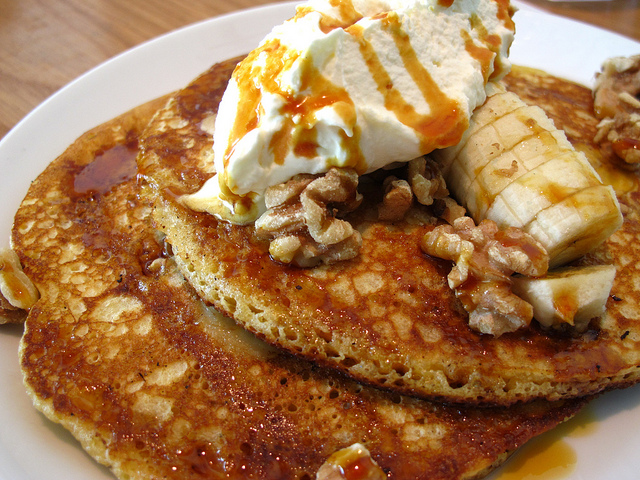

In [104]:
print(train_captions[5000])
Image.open(img_path_list[5000])

In [102]:
print(len(train_captions))
print(len(img_path_list))

5001
5001


# Data Preprocessing

In [126]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [127]:
img_demo, img_path_demo = load_image('/content/train2014/COCO_train2014_000000000025.jpg')
img_demo.shape

TensorShape([299, 299, 3])

# Initializing Inception-ResNet v1 and loading the pretrained Imagenet weights

In [136]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model

pre_trained_model = InceptionV3(include_top=False, weights='imagenet')
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_797 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_801 (BatchN (None, None, None, 3 96          conv2d_797[0][0]                 
__________________________________________________________________________________________________
activation_797 (Activation)     (None, None, None, 3 0           batch_normalization_801[0][0]    
_______________________________________________________________________________________

In [137]:
bottleneck_input = pre_trained_model.input
bottleneck_output = pre_trained_model.get_layer('conv2d_890').output

In [138]:
print(bottleneck_input)
print(bottleneck_output)

Tensor("input_6:0", shape=(None, None, None, 3), dtype=float32)
Tensor("conv2d_890/Conv2D:0", shape=(None, None, None, 192), dtype=float32)


In [145]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

bottleneck_model = Model(inputs=bottleneck_input, 
                         outputs=bottleneck_output)

for layer in bottleneck_model.layers:
  layer.trainable=False

model = tf.keras.Sequential()
model.add(bottleneck_model)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

# x=layers.MaxPooling2D(pool_size=(2, 2))(bottleneck_output)
# x=layers.BatchNormalization()(x)
#x=layers.MaxPooling2D(pool_size=(2, 2))

# x=layers.Flatten()(bottleneck_output)
# x=layers.Dense(1024, activation='relu')(x)

# combined_model = Model(bottleneck_input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [147]:
!pip install -q tqdm
from tqdm import tqdm

In [148]:
# Get unique images
encode_train = sorted(set(img_path_list))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 63/63 [04:17<00:00,  4.08s/it]
